In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.cluster import contingency_matrix


from scipy.stats import f_oneway
import numpy as np

# Carga del dataset

In [60]:
# load file
df = pd.read_csv('data/fact_application_v2_preprocessed.csv')

# Implementación del modelo

In [61]:
# apply dbscan
from sklearn.cluster import DBSCAN

# Compute DBSCAN
db = DBSCAN(eps=0.2, min_samples=11).fit(df.drop(columns=['applicationcode']))
labels = db.labels_
df['Cluster'] = labels

In [62]:
df['Cluster'].value_counts()

 0    501
-1     53
Name: Cluster, dtype: int64

c:\Users\fede_\anaconda3\envs\py310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


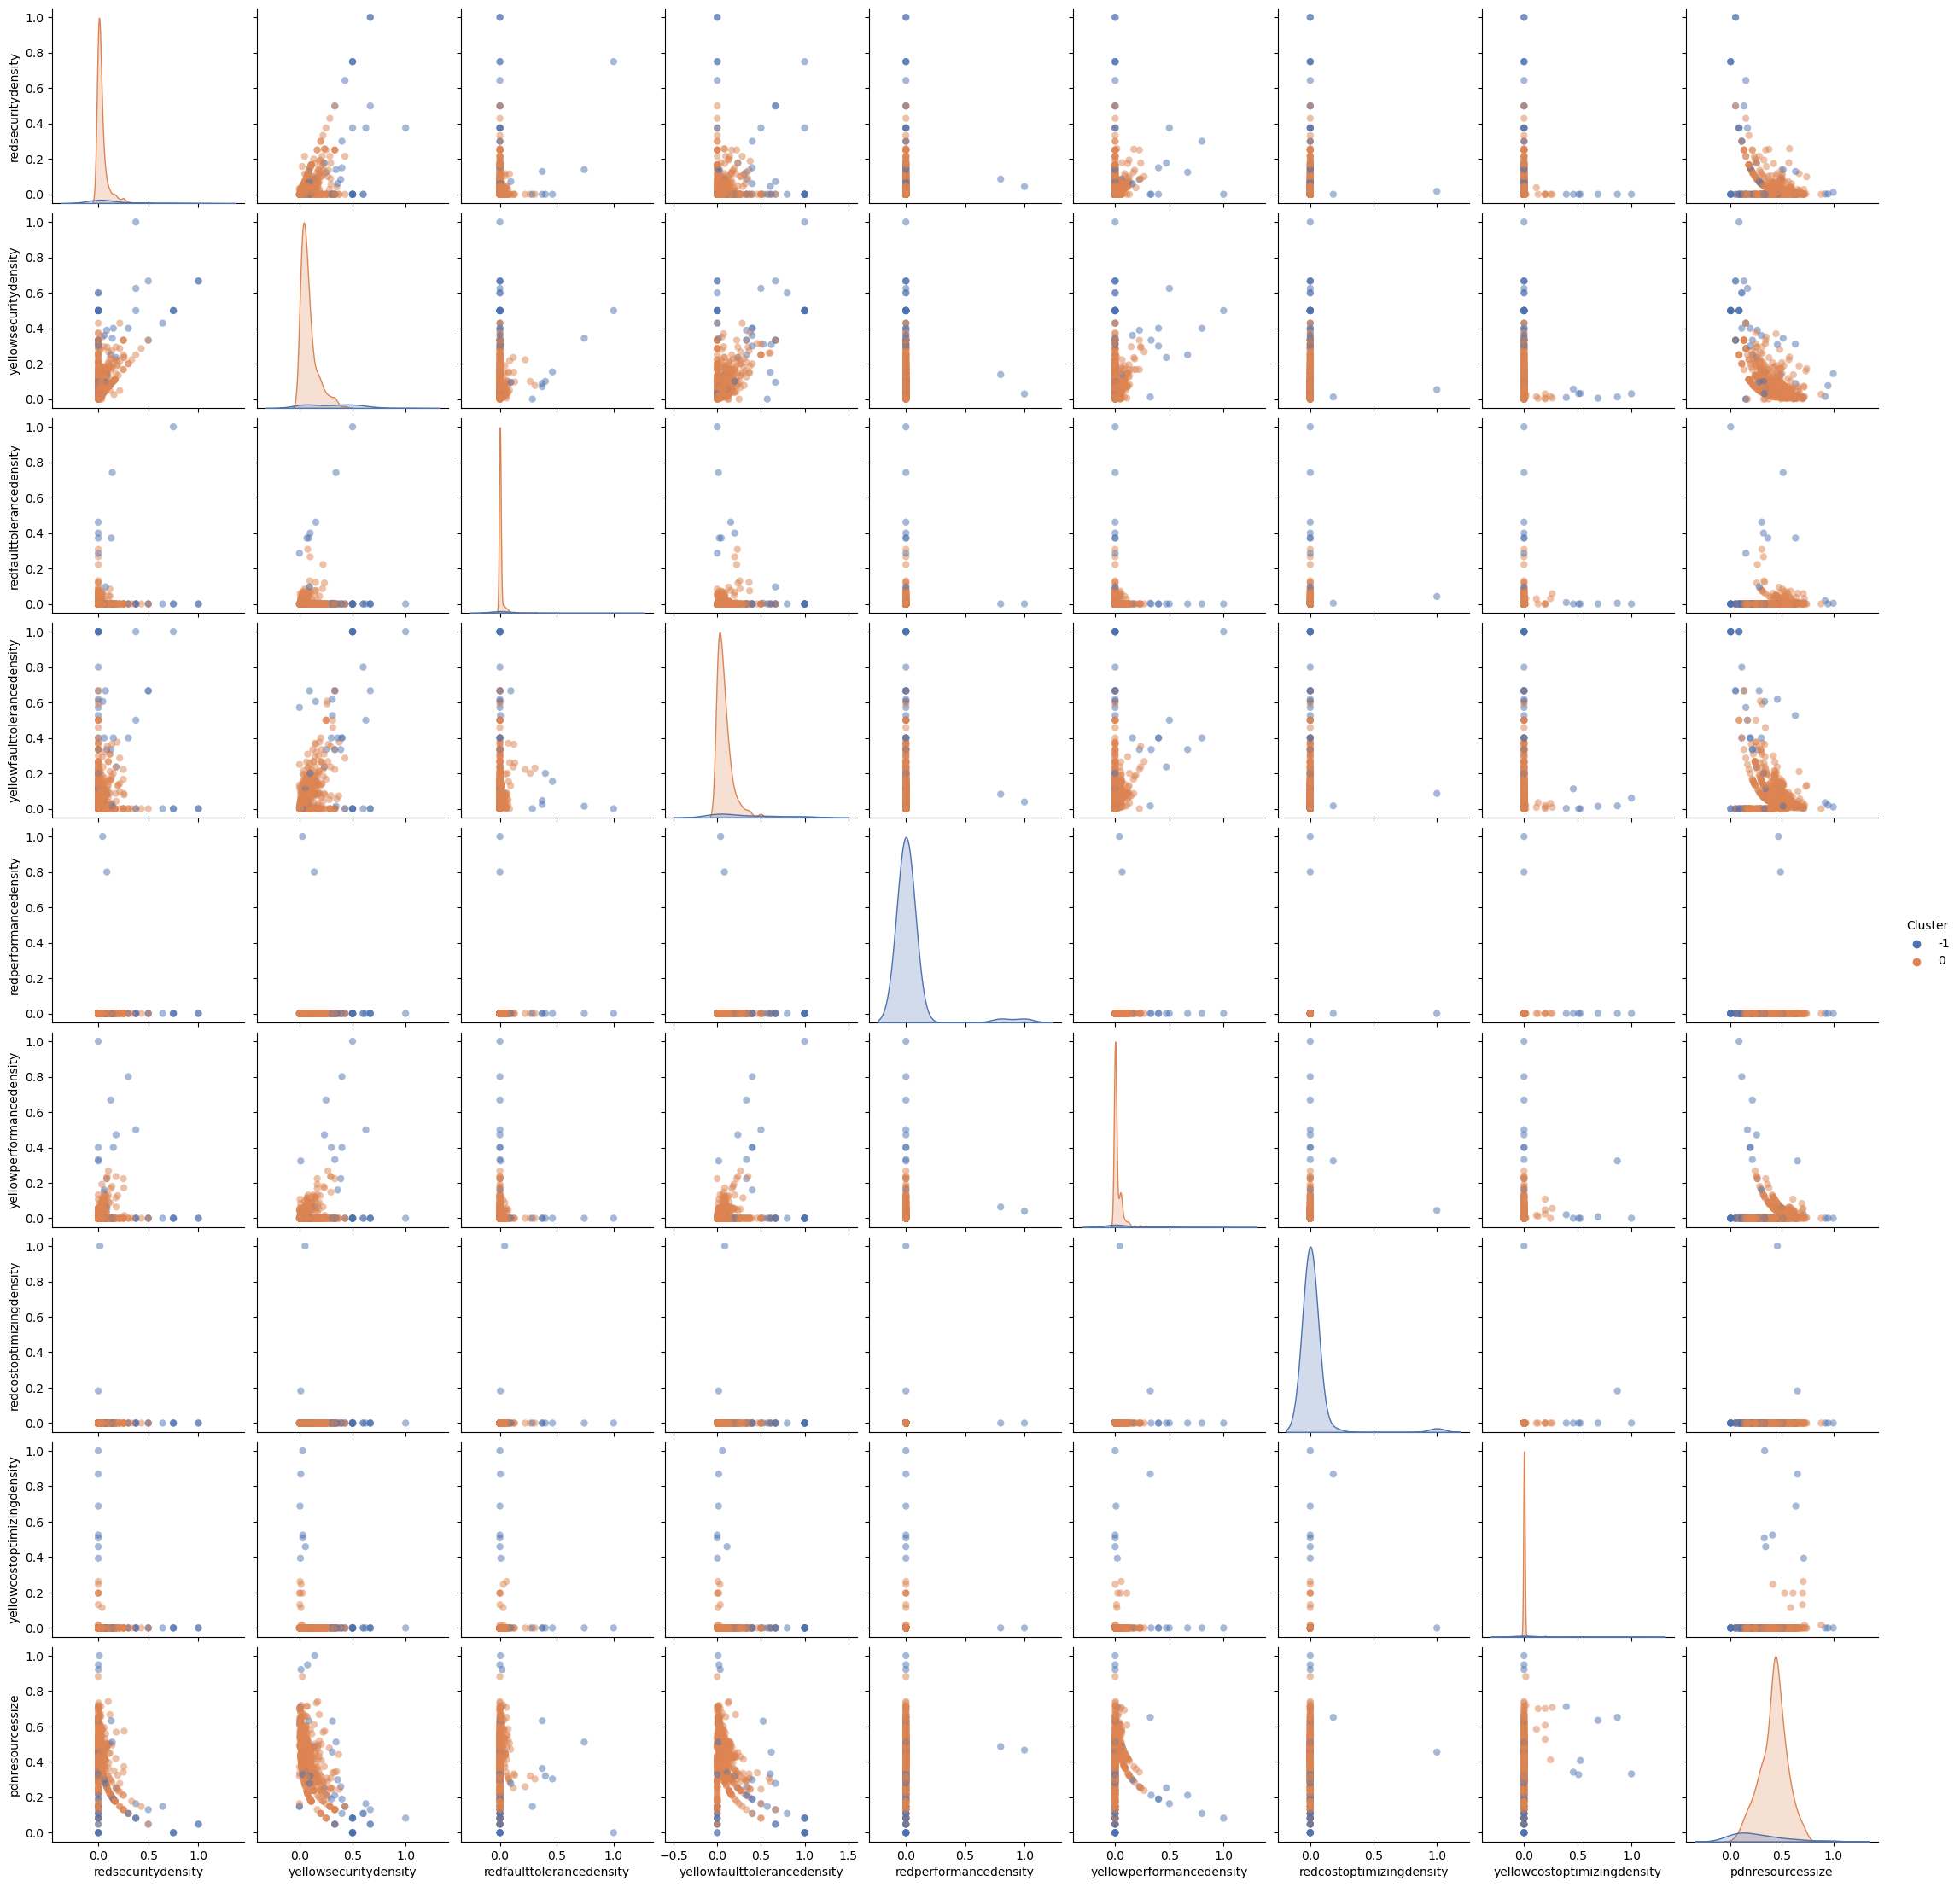

In [63]:
# pairplot
sns.pairplot(df, hue="Cluster", palette="deep", plot_kws=dict(alpha=.5, edgecolor='none'))

In [64]:
# calculate the mean of every cluster
df.groupby('Cluster').mean().T

C:\Users\fede_\AppData\Local\Temp\ipykernel_21412\657990919.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('Cluster').mean().T


Cluster,-1,0
redsecuritydensity,0.159515,0.036515
yellowsecuritydensity,0.308340,0.085663
redfaulttolerancedensity,0.071887,0.006723
yellowfaulttolerancedensity,0.340302,0.082982
redperformancedensity,0.033962,0.000000
yellowperformancedensity,0.102943,0.019337
redcostoptimizingdensity,0.022298,0.000000
yellowcostoptimizingdensity,0.083823,0.002749
pdnresourcessize,0.279128,0.417858


# Metodo de la Silueta

For eps = 0.2, min_samples = 11 the average silhouette_score is : 0.7607158089623817


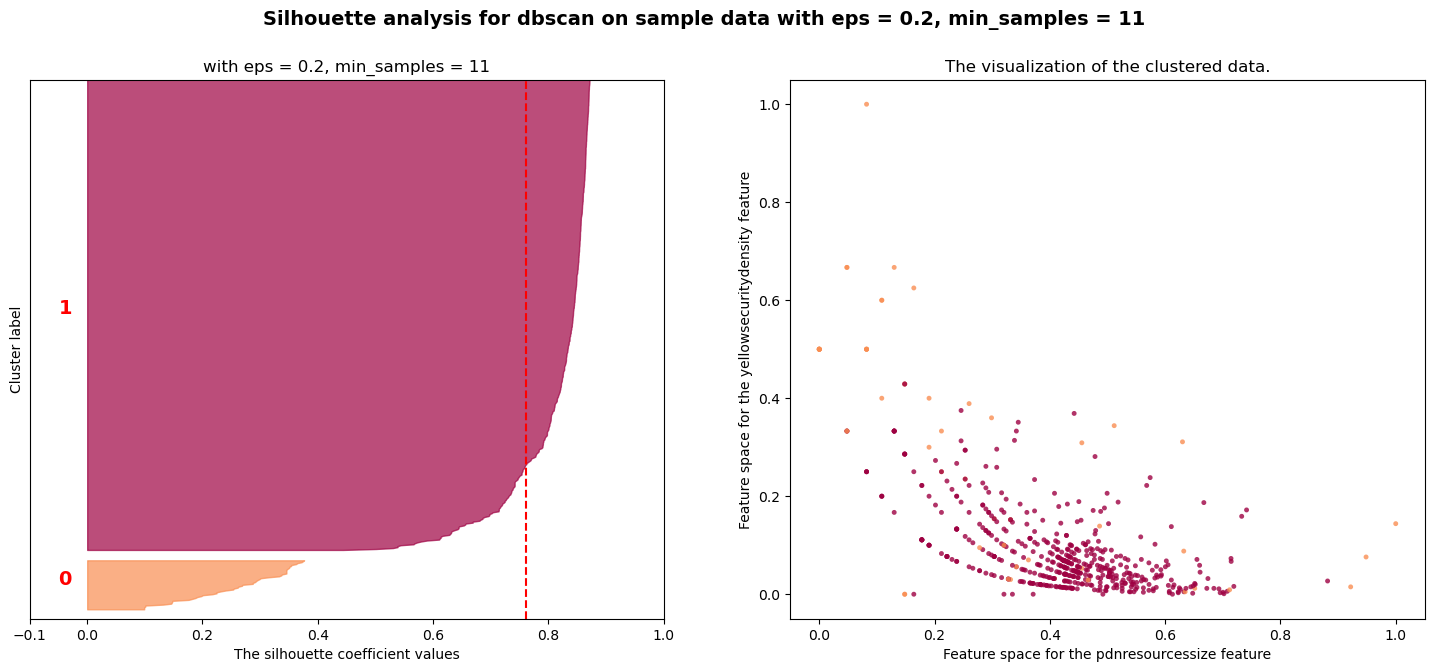

In [65]:
## apply silhouette score
from sklearn.metrics import silhouette_samples, silhouette_score


for K in [0.2]:
    for M in range(11,12):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(df) + (K + 1) * 15])

        db = DBSCAN(eps=K, min_samples=M)
        db.fit(df.drop(columns=['applicationcode']))
        clusters = db.labels_

        silhouette_avg = silhouette_score(df.drop(columns=['applicationcode']), clusters)
        print(f"For eps = {K}, min_samples = {M} the average silhouette_score is : {silhouette_avg}")

        sample_silhouette_values = silhouette_samples(df.drop(columns=['applicationcode']), clusters)

        y_lower = 10
        for i in np.unique( clusters ):
            ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.colormaps.get_cmap("Spectral")(abs(float(i))*0.5 / len(np.unique( clusters )))
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
                )

            ax1.text(
                -0.05,
                y_lower + 0.5 * size_cluster_i,
                str(int(i+1)),
                color="red",
                fontweight="bold",
                fontsize=14,
                )

            y_lower = y_upper + 10
        
        
        ax1.set_title(f"with eps = {K}, min_samples = {M}")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        colors = plt.colormaps.get_cmap("Spectral")(abs(clusters.astype(float))*0.5 / len(np.unique( clusters )))
        ax2.scatter(df['pdnresourcessize'], df['yellowsecuritydensity'], marker='.', s=50, lw=0, alpha=0.8, c=colors, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the pdnresourcessize feature")
        ax2.set_ylabel("Feature space for the yellowsecuritydensity feature")
        
        plt.suptitle(
            (
                f"Silhouette analysis for dbscan on sample data "
                f"with eps = {K}, min_samples = {M}"
            ),
            fontsize=14,
            fontweight="bold",
            )

        # insert
        plt.show()

# Validación
Para la validación vamos a utilizar un dataset con aplicaciones que fueron agrupadas por un experto. Este dataset contiene 100 aplicaciones y cada una de ellas tiene un grupo asignado. El objetivo es comparar los grupos asignados por el experto con los grupos que se obtuvieron con el algoritmo de clustering. 
<br>Es necesario realizar algunos modificaciones en el etiquetado de los clusters para poder calcular la precisión de los resultados obtenidos.

In [66]:
# calculate purity
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contmatrix = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contmatrix, axis=0)) / np.sum(contmatrix)

In [67]:
from sklearn.preprocessing import MinMaxScaler

df_test = pd.read_csv('data/fact_application_to_validation.csv')
df_test = df_test.filter(regex='pdnresourcessize|density|clasification')

# change clasification column values to 0,1 and 2
df_test['clasification'] = df_test['clasification'].replace('Red', 0)
df_test['clasification'] = df_test['clasification'].replace('Yellow', 1)
df_test['clasification'] = df_test['clasification'].replace('Green', 2)

scaler = MinMaxScaler()
df_test_scaled = scaler.fit_transform(df_test['pdnresourcessize'].values.reshape(-1,1))
df_test_scaled = pd.DataFrame(df_test_scaled, columns=['pdnresourcessize'], index=df_test.index)
df_test_scaled = pd.concat([df_test.drop(columns=['pdnresourcessize']), df_test_scaled], axis=1)

In [68]:
# Compute DBSCAN
db = DBSCAN(eps=0.2, min_samples=11).fit(df_test_scaled.drop(columns=['clasification']))
labels = db.labels_
df_test_scaled['Cluster'] = labels

df_test_scaled['Cluster'].value_counts()

 0    90
-1    12
Name: Cluster, dtype: int64

In [69]:
# remplazar 0 (rojo) por -1
df_test_scaled['clasification'] = df_test_scaled['clasification'].replace(0, -1)
# remplazar 1, 2 (yellow y green) por 0, que es el grupo de dbscan
df_test_scaled['clasification'] = df_test_scaled['clasification'].replace(1, 0)
df_test_scaled['clasification'] = df_test_scaled['clasification'].replace(2, 0)

In [58]:
purity_score(df_test_scaled['clasification'], df_test_scaled['Cluster'])

0.9803921568627451